In [1]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import shap
from shap import plots

import pickle

import pathlib
from glob import glob
from data_loader import get_agg_dfs_filepaths, get_agg_dfs_filepaths_philosophy
from config import textbook_words

# 0. Create dataset from the book's agg csv

In [2]:
DATA_DIR_PATH = "../data/"
PDF_SOURCE_DIR_PATH = DATA_DIR_PATH + "pdf/"
PROCESSED_DATA_DIR_PATH = DATA_DIR_PATH + "processed/"

In [3]:
file_paths = get_agg_dfs_filepaths(PROCESSED_DATA_DIR_PATH)
file_paths

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2015_Book_LinearAlgebra/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2007BoolosComputability and Logic Fifth Edition/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/2014_Book_Microeconomics/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/jacobson_14/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/moltmann_97/ag

In [4]:
file_paths_philo = get_agg_dfs_filepaths_philosophy(PROCESSED_DATA_DIR_PATH)
file_paths_philo

['/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/lycan_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/christensen_04/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/williamson_94/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/morris_07/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/peregrin_17/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/shapiro_97/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/linnebo_18/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/processed/philosophy/jenkins_08/aggregated.csv',
 '/Users/bertagrim/dev_projects/final_project/index_generator/data/

In [290]:
list_agg_dfs=[]
for path in file_paths:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df = pd.concat(list_agg_dfs)

In [291]:
list_agg_dfs=[]
for path in file_paths_philo:
    aggregated_df = pd.read_csv(path,index_col=0)
    list_agg_dfs.append(aggregated_df)
    
df_s = pd.concat(list_agg_dfs)

In [ ]:
df.info()

In [ ]:
df_s.info()

# 1. Feature engineering

In [293]:
df.reset_index(drop=True, inplace=True)
df_s.reset_index(drop=True, inplace=True)

In [296]:
df.dropna(inplace=True)
df_s.dropna(inplace=True)

In [299]:
dict_tbw={}
for w in df.candidate_keyword:
    if w in textbook_words:
        dict_tbw[w]=1
    else:
        dict_tbw[w]=0

In [300]:
dict_tbw_s={}
for w in df_s.candidate_keyword:
    if w in textbook_words:
        dict_tbw_s[w]=1
    else:
        dict_tbw_s[w]=0

In [301]:
def is_a_tbw(x):
    if w in textbook_words:
        return 1
    else: 
        return 0

In [302]:
df['is_a_textbook_word']=df.candidate_keyword.apply(lambda x: dict_tbw[x])

In [303]:
df_s['is_a_textbook_word']=df_s.candidate_keyword.apply(lambda x: dict_tbw_s[x])

In [304]:
df_scaled = pd.get_dummies(df, columns=['POS'],
prefix = ['POS'])

In [305]:
df_s_scaled = pd.get_dummies(df_s, columns=['POS'],
prefix = ['POS'])

In [ ]:
df_scaled.head()

In [ ]:
df_s_scaled.head()

In [307]:
df_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [308]:
df_s_scaled.drop(columns=['candidate_keyword'], inplace=True)

In [309]:
df_scaled_columns = df_scaled.columns

In [310]:
df_s_scaled_columns = df_s_scaled.columns

In [311]:
scaler = MinMaxScaler() 

In [312]:
df_scaled = scaler.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns= df_scaled_columns)

In [313]:
df_s_scaled = scaler.fit_transform(df_s_scaled)
df_s_scaled = pd.DataFrame(df_s_scaled, columns= df_s_scaled_columns)

In [314]:
df_scaled=df_scaled.rename(columns={"is_in_index": "target"})

In [315]:
df_s_scaled=df_s_scaled.rename(columns={"is_in_index": "target"})

In [ ]:
df_scaled=df_scaled.drop(columns=['POS_SYM', 
                                        'POS_PART', 
                                        'POS_PUNCT', 
                                        'POS_INTJ', 
                                        'POS_DET',
                                        'POS_AUX',
                                        'POS_SCONJ',
                                        'POS_CCONJ',
                                        'POS_X',
                                        'POS_PRON',
                                        'POS_ADP',
                                        'POS_NUM'], errors='ignore)

In [320]:
df_s_scaled=df_s_scaled.drop(columns=['POS_SYM', 
                                        'POS_PART', 
                                        'POS_PUNCT', 
                                        'POS_INTJ', 
                                        'POS_DET',
                                        'POS_AUX',
                                        'POS_SCONJ',
                                        'POS_CCONJ',
                                        'POS_X',
                                        'POS_PRON',
                                        'POS_ADP',
                                        'POS_NUM'], errors='ignore')

In [ ]:
df_scaled.info()

In [ ]:
df_s_scaled.info()

In [ ]:
df_scaled.to_csv("../data/final_scaled.csv", encoding = 'utf-8')

In [ ]:
df_s_scaled.to_csv("../data/final_scaled_small.csv", encoding = 'utf-8')

# 2. Quick EDA

In [ ]:
path = '../data/final_scaled.csv'
df_scaled = pd.read_csv(path,index_col=0)
df_scaled.info()

In [ ]:
path = '../data/final_scaled_small.csv'
df_s_scaled = pd.read_csv(path,index_col=0)
df_s_scaled.info()

### Correlation heatmap

In [ ]:
plt.figure(figsize=(4, 10))

heatmap = sns.heatmap(df_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [ ]:
heatmap.figure.savefig("../images/heatmap.png", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(4, 10))

heatmap_s = sns.heatmap(df_s_scaled.corr()[['target']].sort_values(by='target', ascending=False), 
                      vmin=-1, 
                      vmax=1,
                      annot=True,
                      cmap='BrBG')

heatmap_s.set_title('Index Correlation', fontdict={'fontsize':18}, pad=16);

plt.show()

In [ ]:
heatmap_s.figure.savefig("../images/heatmap_s.png", bbox_inches="tight")

### Visualization (types of books)

In [164]:
types_books={'Philosophy': 10, 'Linguistics': 6,  'Logic': 2, 'Economics': 1,  'Data Science': 1, 'Maths': 1, 'Astronomy': 1}

In [165]:
keys = list(types_books.keys())
vals = [types_books[k] for k in keys]

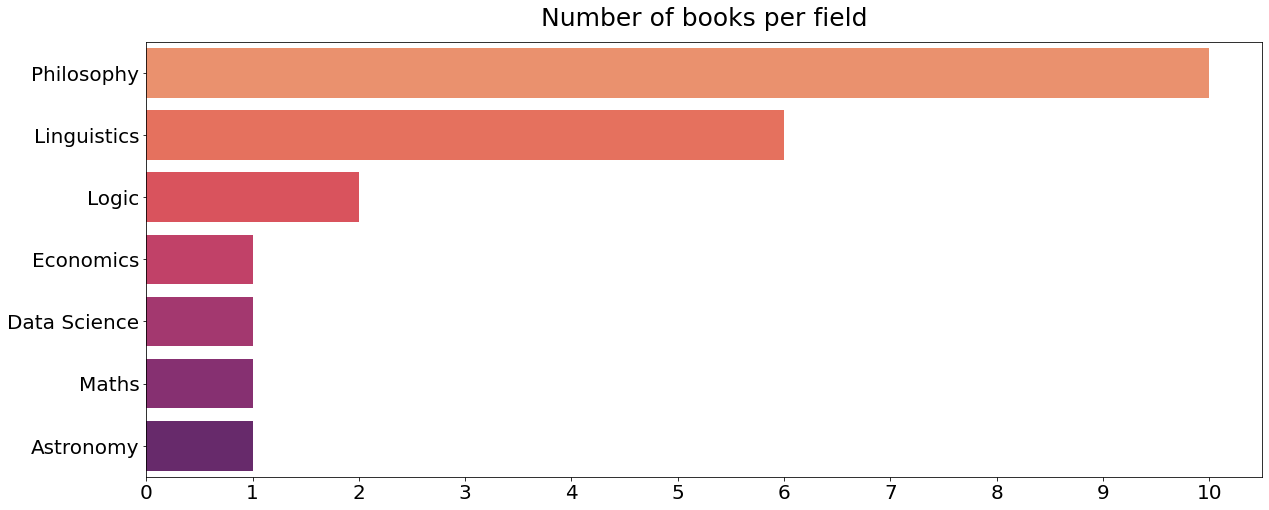

In [453]:
plt.figure(figsize=(20, 8))
types_of_books=sns.barplot(y=keys, x=vals, palette="flare", saturation=1)
types_of_books.set_title('Number of books per field', fontdict={'fontsize':25}, pad=16)
plt.xticks(np.arange(0, 11, 1.0))
plt.tick_params(axis='y', which='major', labelsize=20)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.show()

In [454]:
types_of_books.figure.savefig("../images/types_of_books.png", bbox_inches="tight")

# 3. Train and test the models

In [180]:
X = df_scaled.drop('target', axis= 1)
y = df_scaled.target

In [181]:
X_s = df_s_scaled.drop('target', axis= 1)
y_s = df_s_scaled.target

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

In [183]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.3,
                                                    random_state=42, stratify=y_s)

### 3.1. Oversampling with SMOTE

In [328]:
smote = SMOTE(random_state=42)

In [ ]:
X_sm,y_sm=smote.fit_resample(X_train, y_train)

In [ ]:
X_sm_s,y_sm_s=smote.fit_resample(X_s_train, y_s_train)

In [ ]:
pickle.dump(X_sm, open('../models/X_sm.sav', 'wb'))
pickle.dump(y_sm, open('../models/y_sm.sav', 'wb'))

In [ ]:
pickle.dump(X_sm_s, open('../models/X_sm_s.sav', 'wb'))
pickle.dump(y_sm_s, open('../models/y_sm_s.sav', 'wb'))

In [184]:
X_sm = pickle.load(open('../models/X_sm.sav', 'rb'))
y_sm = pickle.load(open('../models/y_sm.sav', 'rb'))

In [10]:
X_sm_s = pickle.load(open('../models/X_sm_s.sav', 'rb'))
y_sm_s = pickle.load(open('../models/y_sm_s.sav', 'rb'))

In [ ]:
print('\nBefore OVER-sampling\n', y_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm.value_counts())

In [ ]:
print('\nBefore OVER-sampling\n', y_s_train.value_counts())
print('\nAfter OVER-sampling\n', y_sm_s.value_counts())

### 3.2. XGBoost classifier

### Big dataset

In [342]:
xgb_model=xgb.XGBClassifier(random_state=42)

In [ ]:
xgb_mod=xgb_model.fit(X_train,y_train.values.ravel()) 

In [ ]:
pickle.dump(xgb_mod, open('../models/xgb_mod.sav', 'wb'))

In [ ]:
xgb_mod = pickle.load(open('../models/xgb_mod.sav', 'rb'))

In [ ]:
y_pred_xgb = xgb_mod.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_xgb)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_xgb)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_xgb)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_xgb)))

### Big dataset with SMOTE

In [ ]:
xgb_mod_sm=xgb_model.fit(X_sm,y_sm.values.ravel()) 

In [13]:
pickle.dump(xgb_mod_sm, open('../models/xgb_mod_sm.sav', 'wb'))

In [178]:
xgb_mod_sm = pickle.load(open('../models/xgb_mod_sm.sav', 'rb'))

In [15]:
y_pred_xgb_sm = xgb_mod_sm.predict(X_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_xgb_sm)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_xgb_sm)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_xgb_sm)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_xgb_sm)))

### Small dataset

In [ ]:
xgb_mod_s=xgb_model.fit(X_s_train,y_s_train.values.ravel()) 

In [ ]:
pickle.dump(xgb_mod_s, open('../models/xgb_mod_s.sav', 'wb'))

In [ ]:
xgb_mod_s = pickle.load(open('../models/xgb_mod_s.sav', 'rb'))

In [ ]:
y_pred_xgb_s = xgb_mod_s.predict(X_s_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_xgb_s)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_xgb_s)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_xgb_s)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_xgb_s)))

### Small dataset with SMOTE

In [ ]:
xgb_mod_s_sm=xgb_mod.fit(X_sm_s,y_sm_s.values.ravel()) 

In [18]:
pickle.dump(xgb_mod_s_sm, open('../models/xgb_mod_s_sm.sav', 'wb'))

In [177]:
xgb_mod_s_sm = pickle.load(open('../models/xgb_mod_s_sm.sav', 'rb'))

In [22]:
y_pred_xgb_s_sm = xgb_mod_s_sm.predict(X_s_test)

In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_s_test,y_pred_xgb_s_sm)))
print('Precision Score : ' + str(precision_score(y_s_test,y_pred_xgb_s_sm)))
print('Recall Score : ' + str(recall_score(y_s_test,y_pred_xgb_s_sm)))
print('F1 Score : ' + str(f1_score(y_s_test,y_pred_xgb_s_sm)))

## 4. Explainability

### 4.1 Feature importance

In [ ]:
importance_xgb_sm = xgb_mod_sm.feature_importances_

list_of_importance_xgb_sm=zip(X.columns.tolist(), importance_xgb_sm.tolist())

In [ ]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_xgb_sm))]
labels = X_train.columns.tolist()
plt.bar(arr, importance_xgb_sm)
plt.title('Feature importance XGBoost')
plt.xticks(arr, labels, rotation=90)
plt.show()

In [ ]:
importance_xgb_s = xgb_mod_s.feature_importances_

list_of_importance_xgb_s=zip(X.columns.tolist(), importance_xgb_s.tolist())

In [ ]:
plt.figure(figsize=(10, 6))

arr = [x for x in range(len(importance_xgb_s))]
labels = X_train.columns.tolist()
plt.bar(arr, importance_xgb_s)
plt.title('Feature importance XGBoost (small)')
plt.xticks(arr, labels, rotation=90)
plt.show()

### 4.2. SHAP plots

### Summary plots

In [ ]:
explainer_xgb = shap.TreeExplainer(xgb_mod)
shap_values_xgb = explainer_xgb.shap_values(X)
expected_value_xgb = explainer_xgbr.expected_value

In [ ]:
pickle.dump(shap_values_xgb, open('../models/shap_values_xgb.sav', 'wb'))

In [ ]:
pickle.dump(expected_value_xgb, open('../models/expected_value_xgb.sav', 'wb'))

In [ ]:
shap.summary_plot(shap_values_xgb, X,title="SHAP summary XGB", show=False)
plt.savefig('../images/shap_summary_xgb.png')

In [ ]:
explainer_xgb_s = shap.TreeExplainer(xgb_mod_s)
shap_values_xgb_s = explainer_xgb_s.shap_values(X_s)
expected_value_xgb_s = explainer_xgb_s.expected_value

In [ ]:
pickle.dump(shap_values_xgb_s, open('../models/shap_values_xgb_s.sav', 'wb'))

In [ ]:
pickle.dump(expected_value_xgb_s, open('../models/expected_value_xgb_s.sav', 'wb'))

In [ ]:
shap.summary_plot(shap_values_xgb_s, X,title="SHAP summary XGB (small dataset)", show=False)
plt.savefig('../images/shap_summary_xgb_s.png')

### Barplot (for big dataset only)

In [369]:
shap_values_xgb_1=explainer_xgb(X)

In [370]:
pickle.dump(shap_values_xgb_1, open('../models/expected_value_xgb_1.sav', 'wb'))

In [392]:
shap_values_xgb_1 = pickle.load(open('../models/expected_value_xgb_1.sav', 'rb'))

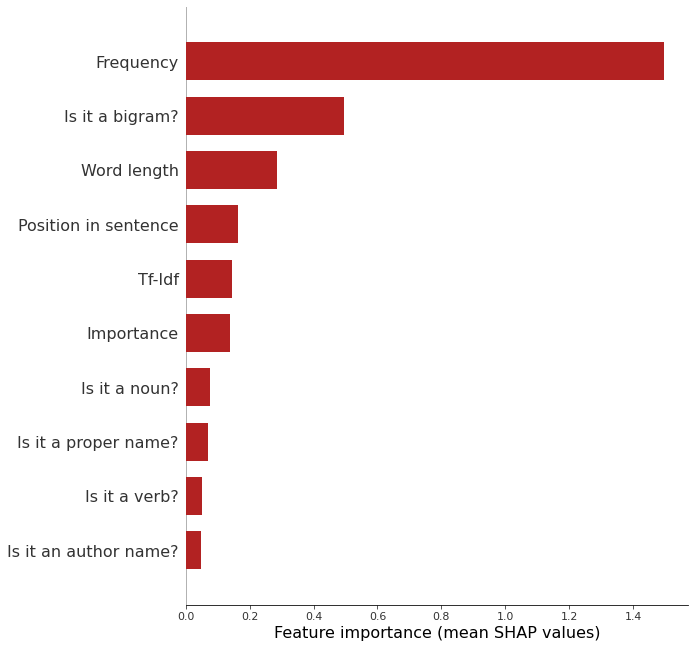

In [456]:
shap.summary_plot(shap_values_xgb_1, X, plot_type="bar", color='firebrick', max_display=10,show=False)
fig = plt.gcf() # gcf means "get current figure"
fig.set_figheight(11)
fig.set_figwidth(9)
ax = plt.gca()
labels=['Is it an author name?','Is it a verb?','Is it a proper name?','Is it a noun?','Importance','Tf-Idf','Position in sentence','Word length','Is it a bigram?','Frequency']
ax.set_yticklabels(labels, fontsize=16)
ax.set_xlabel("Feature importance (mean SHAP values)", fontsize=16)

plt.savefig('../images/shap_summary_xgb1.png', bbox_inches="tight")

### Appendix: Visualization (comparison metrics)

In [373]:
comparison_metrics=[['Accuracy','General model',0.9906481704802732],
                    ['Accuracy','Philosophy model',0.992522026924281],
                    ['Precision','General model',0.7207505518763797],
                    ['Precision','Philosophy model',0.7841328413284133], 
                    ['Recall','General model', 0.23288159771754635],
                    ['Recall','Philosophy model',0.3715034965034965],
                    ['F1 score','General model',0.35202156334231804],
                    ['F1 score','Philosophy model',0.5041518386714117]]

In [374]:
comparison_metrics_df=pd.DataFrame(comparison_metrics, columns=['Metric','Model', 'Value'])

In [375]:
comparison_metrics_df

,Metric,Model,Value
0,Accuracy,General model,0.990648
1,Accuracy,Philosophy model,0.992522
2,Precision,General model,0.720751
3,Precision,Philosophy model,0.784133
4,Recall,General model,0.232882
5,Recall,Philosophy model,0.371503
6,F1 score,General model,0.352022
7,F1 score,Philosophy model,0.504152


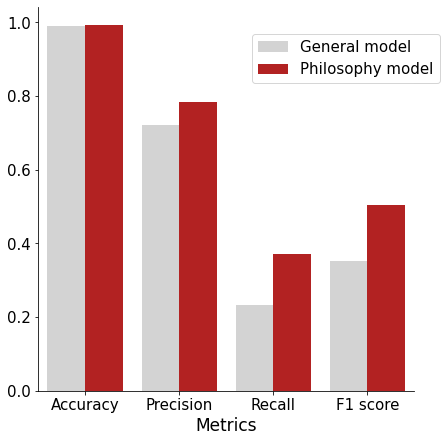

In [457]:
comparison_metrics_img = sns.catplot(
    data=comparison_metrics_df, kind="bar",
    x="Metric", y="Value", hue="Model", saturation=1,
    ci="sd", palette=['lightgrey','firebrick'], height=6, legend=False
)

plt.xlabel('Metrics',fontsize=17)
plt.ylabel('')
plt.tick_params(axis='both', labelsize=15)


plt.legend(loc = 2,fontsize=15, bbox_to_anchor = (0.55,0.95))

plt.savefig("../images/comparison_metrics_img.png", bbox_inches="tight")